# **CheXpert**
##### **Project description**
CheXpert is a large public dataset for chest radiograph interpretation, consisting of 224,316 chest radiographs of 65,240 patients. Each radiograph is labeled for presence of 14 classes as positive (1), negative (0), or uncertain (-1).

![train.csv](https://stanfordmlgroup.github.io/competitions/chexpert/img/table1.png)

##### **Downloading the dataset**
Because the original dataset is over 600 GB in size, 10 GB reduced dataset will be used to comply with restrictions of Google Colab environment. Additionally, 1/5 sample of the reduced dataset is created to achieve faster testing. Both datasets are uploaded to personal Google Drive and made public, links to them are saved. Swapping between the datasets is done by changing RUN_SAMPLE constant.

CheXpert project link: https://stanfordmlgroup.github.io/competitions/chexpert/

Reducted CheXpert link: https://www.kaggle.com/datasets/ssttff/chexpertv10small

**Import packages and set constants**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from pandas import read_csv
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import layers, metrics, regularizers, Sequential
from tensorflow.keras.utils import load_img
from tensorflow.keras.optimizers import Adam

RUN_SAMPLE = True

LINK_SAMPLE = "https://drive.google.com/uc?id=1GOBls6bYWFytXvQDPOMU7xRLlMSs2BxS"
LINK_DATA = "https://drive.google.com/uc?id=1nD1-hgXspxh7H2By0A8CnLVrTva0nCny"

PATH_ZIP = "/content/CheXpert-v1.0-small.tar"
PATH_DATA = "/content/CheXpert-v1.0-small/"
PATH_TRAIN_CSV = PATH_DATA + 'train.csv'
PATH_TEST_CSV = PATH_DATA + 'valid.csv'

FEATURES = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]
FEATURES_SIZE = len(FEATURES)

IMAGE_HEIGHT = 320
IMAGE_WIDTH = 390
CHANNELS = 1

IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH)
TENSOR_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)

**Download data from google drive to colab**

In [ ]:
if not os.path.isdir(PATH_DATA):
  !pip install gdown==4.6.0
  download_link = LINK_SAMPLE if RUN_SAMPLE else LINK_DATA

  !gdown $download_link
  !tar -xvf  $PATH_ZIP

Streaming output truncated to the last 5000 lines.
CheXpert-v1.0-small/train/patient09454/
CheXpert-v1.0-small/train/patient09454/study1/
CheXpert-v1.0-small/train/patient09454/study1/view1_frontal.jpg
CheXpert-v1.0-small/train/patient09455/
CheXpert-v1.0-small/train/patient09455/study1/
CheXpert-v1.0-small/train/patient09455/study1/view1_frontal.jpg
CheXpert-v1.0-small/train/patient09456/
CheXpert-v1.0-small/train/patient09456/study1/
CheXpert-v1.0-small/train/patient09456/study1/view1_frontal.jpg
CheXpert-v1.0-small/train/patient09456/study1/view2_lateral.jpg
CheXpert-v1.0-small/train/patient09457/
CheXpert-v1.0-small/train/patient09457/study1/
CheXpert-v1.0-small/train/patient09457/study1/view1_frontal.jpg
CheXpert-v1.0-small/train/patient09457/study10/
CheXpert-v1.0-small/train/patient09457/study10/view1_frontal.jpg
CheXpert-v1.0-small/train/patient09457/study2/
CheXpert-v1.0-small/train/patient09457/study2/view1_frontal.jpg
CheXpert-v1.0-small/train/patient09457/study3/
CheXpert-v

# **Loading and preprocessing the dataset**
The dataset consists of JPEG images scattered across many folders. At the root, it also contains train.csv and test.csv files with labels:

![train.csv](https://drive.google.com/uc?export=view&id=1twUjd2B1ISa7ETdX9eYzg08oFBrqkUgv)

#### **Loading the data**
Instead of searching the directory tree for JPEG images, Path variable in train.csv can be utilized to directly connect image to a corresponding row (label). At the same time, images should not be loaded into the DataFrame itself (or somewhere else) because of size of the dataset - this is what was attempted intially, but the environment will run out of RAM while training very quickly. Instead, tf.data.Dataset.from_generator is used to create generator object that tensorflow uses to load images into RAM as needed. This will cause training to become a lot slower, because the images will be loaded and dropped on demand.

#### **Labels**
Every image has 14 classes where multiple of them can be true. Essentially all of the observations have either missing class value (null), or uncertain class value (-1). I decided the most reasonable solution is to assume negative (0) for these cases, which will turn the problem into a multi-label problem and labels can be encoded into multi-hot encoding. The label is then a 14 element array, where each element represents presence of the given class.

#### **Images**
The images use grayscale format. Size of the images varies slightly, therefore the images are resized to 320x390 pixels when loading. Images are then converted to NumPy arrays of shape (320, 390, 1).



**Create training, validation and testing datasets:**

In [ ]:
def dataset_generator(df):
    def read_image(path):
        image = load_img('/content/' + path,
                          color_mode='grayscale',
                          target_size=IMAGE_SHAPE)
        return np.array(image)[:, :, np.newaxis]

    df = df.loc[df['Path'].str.contains('frontal'), :].replace(-1, 0).fillna(0)

    for i, row in df.iterrows():
        image = read_image(row['Path'])
        label = row[FEATURES].to_numpy()
        yield image, label


# Load CSV
train_data = read_csv(PATH_TRAIN_CSV)
test_data = read_csv(PATH_TEST_CSV)

# Split train data into train + validation
train_data = train_data.sample(frac=1) # Shuffle
split = int(train_data.shape[0]*0.8)
train_data, validation_data = train_data[:split], train_data[split:]

# Generate datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_data),
    output_signature=(
        tf.TensorSpec(shape=TENSOR_SHAPE, dtype=tf.float64),
        tf.TensorSpec(shape=FEATURES_SIZE, dtype=tf.float64)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(validation_data),
    output_signature=(
        tf.TensorSpec(shape=TENSOR_SHAPE, dtype=tf.float64),
        tf.TensorSpec(shape=FEATURES_SIZE, dtype=tf.float64)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_data),
    output_signature=(
        tf.TensorSpec(shape=TENSOR_SHAPE, dtype=tf.float64),
        tf.TensorSpec(shape=FEATURES_SIZE, dtype=tf.float64)
    )
)

**Test the generator**

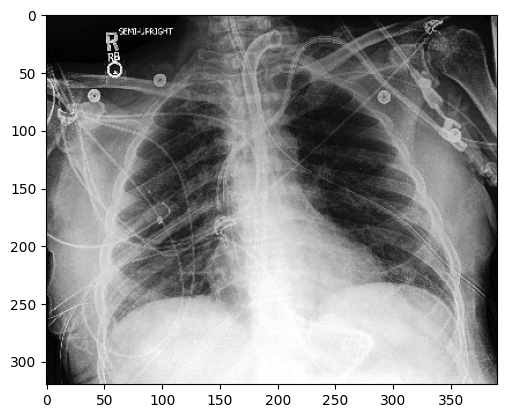

Batch Shape - images: (320, 390, 1)
Batch Shape - labels: (14,)


In [ ]:
for batch_images, batch_labels in dataset_generator(train_data):
    plt.imshow(batch_images, cmap='gray')
    plt.show()
    print("Batch Shape - images:", batch_images.shape)
    print("Batch Shape - labels:", batch_labels.shape)
    break

**Batch and shuffle the data**

In [ ]:
batch_size = 64

train_dataset = (
    train_dataset
    .shuffle(2000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    validation_dataset
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# **Training the neural network**
#### **Hyperparameters**
In a multi-label classification problem with binary observations, suitable loss function is **binary_crossentropy** with **sigmoid** as output layer activation function. As optimizer **Adam** is used.

The shape of the input layer of the network is **(320, 390, 1)**, which is equal to shape of the image numpy arrays. Output layer is of shape **(14,)**, which equals to 14 classes in the label.


The measure of success is **accuracy**, but it's worth tracking **AUC**, **recall** and **precision** as well because of unproportional classes.



**Custom accuracy metric**

For predicted classes [1, 1, 0, 1] and labeled classes [0, 1, 0, 1], Tensorflow in-build accuracy would return 0 %. Taking into account that 14 variables need to be predicted exactly (and that there is a lot of uncertainty in the data) additional custom accuracy function is created that will calculate accuracy element-wise and return 3 / 4 = 75 % accuracy instead. Although this metric is also biased due to unproportional classes, it might serve as additional reference point to how many individual classes are guessed correctly.

In [ ]:
def multilabel_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(tf.greater_equal(y_pred, 0.5), dtype=tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_binary), dtype=tf.float32))

**Architecture 1**

Starting with a simple CNN architecture:
- Rescaling layer
- 2x convolution + 2x pooling
- 50% dropout
- EarlyStopping based on validation loss

The dataset contains relatively large images, therefore convolution and pooling layers will be used to reduce number of parameters and allow the model to focus on more abstract features in the later layers. The model will also likely overfit, therefore 50% dropout is applied.

In [ ]:
inputs = tf.keras.Input(shape=TENSOR_SHAPE)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(FEATURES_SIZE, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
      multilabel_accuracy,
      "accuracy",
      tf.keras.metrics.AUC(),
      tf.keras.metrics.Precision(),
      tf.keras.metrics.Recall()
    ]
)

callbacks = [
  ModelCheckpoint(
    filepath="chexpert_convnet1.tf",
    monitor="val_loss",
    save_best_only=True),
  EarlyStopping(
    monitor="val_loss",
    patience=5
  )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 390, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 320, 390, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 318, 388, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 194, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 192, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 78, 96, 64)        0         
 g2D)                                                        

**Architecture 1 - Conclusion**:

The model shows signs of overfitting almost immediately - training metrics improve, but valuation metrics decline. Trying different kernel sizes and activation functions doesn't seem to have much efect. It will probably be necessary to improve capacity of the neural network and add additional regularization steps.

**Architecture 2**
- add dynamic learning rate function that is based on epochs
- add one additional convolution layer
- add dense layers to allow the model to learn patterns from convolution output



In [ ]:
# Add learning rate
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate / (10 ** (epoch // 10)))

inputs = tf.keras.Input(shape=TENSOR_SHAPE)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

# One additional convolution layer
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)

# Two Dense layers added
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)

outputs = layers.Dense(FEATURES_SIZE, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
  ModelCheckpoint(
      filepath="chexpert_convnet2.tf",
      monitor="val_loss",
      save_best_only=True),
  EarlyStopping(
    monitor="val_loss",
    patience=5
  ),
  lr_schedule
]

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=initial_learning_rate),
    metrics=[
      multilabel_accuracy,
      "accuracy",
      tf.keras.metrics.AUC(),
      tf.keras.metrics.Precision(),
      tf.keras.metrics.Recall()
      ]
)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
403/403 [==============================] - 230s 498ms/step - loss: 0.3645 - multilabel_accuracy: 0.8430 - accuracy: 0.1269 - auc: 0.8031 - precision: 0.5472 - recall: 0.2905 - val_loss: 0.3381 - val_multilabel_accuracy: 0.8554 - val_accuracy: 0.1849 - val_auc: 0.8369 - val_precision: 0.5783 - val_recall: 0.4215 - lr: 0.0010
Epoch 2/30
403/403 [==============================] - 207s 493ms/step - loss: 0.3416 - multilabel_accuracy: 0.8537 - accuracy: 0.1324 - auc: 0.8296 - precision: 0.5962 - recall: 0.3564 - val_loss: 0.3301 - val_multilabel_accuracy: 0.8583 - val_accuracy: 0.1135 - val_auc: 0.8421 - val_precision: 0.6022 - val_recall: 0.3893 - lr: 0.0010
Epoch 3/30
403/403 [==============================] - 213s 511ms/step - loss: 0.3351 - multilabel_accuracy: 0.8567 - accuracy: 0.1382 - auc: 0.8379 - precision: 0.6068 - recall: 0.3788 - val_loss: 0.3300 - val_multilabel_accuracy: 0.8574 - val_accuracy: 0.1009 - val_auc: 0.8436 - val_precision: 0.5797 - val_recall: 0.4605 - 

**Architecture 2 - conclusion**
EarlyStopping stopped the model on 11th epoch after validation loss wasn't improving for 5 epochs and seems to have started overfitting slightly. Overall the model has improved fairly on training data, but just slightly on validation data. When the model says the class is positive, it is 60 % correct and overall is correct in 86 % of cases when it predicts a class. Discrepancy between these two numbers probably means that it favours negative classes due to their higher prevelance in the training data. Images label is predicted correctly (all 14 classes are correct) in ~ 20 % of cases.

**Architecture 3**

- early stopping and model checkpoint uses val_auc
- data augmentation layer added - could help the model generalize and increase validation metrics.
- L2 regularization added to dense layers - attemps to prevent overfitting that occurs after few epochs.


In [ ]:
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate / (10 ** (epoch // 10)))

# Added data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = tf.keras.Input(shape=TENSOR_SHAPE)

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)

# Added L2 regularization
x = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

outputs = layers.Dense(FEATURES_SIZE, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

metrics = [
    multilabel_accuracy,
    "accuracy",
    tf.keras.metrics.AUC(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

# Use val_auc instead of val_loss
callbacks = [
  ModelCheckpoint(
      filepath="chexpert_convnet3.tf",
      monitor="val_auc",
      save_best_only=True),
  EarlyStopping(
    monitor="val_auc",
    patience=5
  ),
  lr_schedule
]

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=initial_learning_rate),
    metrics=metrics
)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 390, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 320, 390, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 318, 388, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 194, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 192, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 78, 96, 64)        0         
 g2D)                                                        

**Architecture 3 - conclusion**

Data augmentation doesn't have much effect, probably because there is already large variety of training data. After applying L1 and L2 regularization to different layers the model doesn't seem to make much progress beyond model architecture 2.

# **Conclusion**
3 neural network architectures were implemented for the Chexpert dataset. The second architecture was able to predict some of the pathologies quite well, reaching beyond 20 % accuracy on predicting the full label and over 80 % on predicting individual labels. It could be beneficial to split the problem into individual classes, predict them separately and model relationship between them.